In [1]:
import os
import tensorflow as tf 
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers.experimental import preprocessing 
from IPython.display import clear_output
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import numpy as np
from tqdm import tqdm
import random

2021-10-04 22:19:48.866816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-04 22:19:48.866832: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#tf.config.run_functions_eagerly(True)

In [3]:
train_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
val_text_file = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
image_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/JPEGImages"
mask_folder = "VOCtrainval_11-May-2012/VOCdevkit/VOC2012/SegmentationClass"

In [4]:
def read_paths_img_masks(text_file_path, image_path, mask_path):
    paths = []
    with open(text_file_path, "r") as file:
        file_names = file.readlines()
    for file_name in tqdm(file_names):
        image = os.path.join(image_path, file_name.strip() + ".jpg")
        mask = os.path.join(mask_path, file_name.strip() + ".png")
        paths.append((image, mask))
    return paths


In [5]:

train_paths = read_paths_img_masks(train_text_file, image_folder, mask_folder)
val_paths = read_paths_img_masks(val_text_file, image_folder, mask_folder)

# Adding 1000 paths from validation dataset to training dataset increase training dataset size
train_paths.extend(val_paths[0:500])
test_paths = val_paths[500:1000]
val_paths = val_paths[1000:]

#train_paths = tf.data.Dataset.from_tensors(train_paths)
#val_paths = tf.data.Dataset.from_tensors(val_paths)


100%|██████████| 1449/1449 [00:00<00:00, 547674.73it/s]


In [6]:

dim = 128
img_size = (dim, dim)
input_shape = [dim, dim, 3]

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask[input_mask == 255] = 21
    return input_image, input_mask


def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = PIL.Image.open(f) 
        img = img.resize(img_size)
        nparr = np.asarray(img)
        #print("nparr:", nparr.shape)
        return nparr

def load_image_and_mask(paths_tuple):
    input_image = load_image_to_array(paths_tuple[0])
    input_mask = load_image_to_array(paths_tuple[1])
    input_image, input_mask = normalize(input_image, input_mask)
    
    return input_image, input_mask


In [7]:
def load_dataset(paths):
    imgs = []
    masks = []
    for path in tqdm(paths):
        #print("Processing: ", path)
        img, mask = load_image_and_mask(path)
        imgs.append(img)
        masks.append(mask)
        #break
    return np.array(imgs), np.array(masks)


In [8]:
print("Loading Training Dataset...")
train_images, train_masks = load_dataset(train_paths)
print("Loading Validation Dataset...")
val_images, val_masks = load_dataset(val_paths)
print("Loading Test Dataset...")
test_images, test_masks = load_dataset(test_paths)

print("Training dataset size:", len(train_images))
print("Test dataset size:", len(test_images))
print("Validation dataset size:", len(val_images))


Loading Training Dataset...


  0%|          | 0/1964 [00:00<?, ?it/s]2021-10-04 22:19:50.148970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-04 22:19:50.149767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-04 22:19:50.149814: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-10-04 22:19:50.149857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-10-04 22:19:50.149899: W tensorflow/stream_execut

Loading Validation Dataset...


100%|██████████| 449/449 [00:02<00:00, 196.23it/s]


Loading Test Dataset...


100%|██████████| 500/500 [00:02<00:00, 196.70it/s]

Training dataset size: 1964
Test dataset size: 500
Validation dataset size: 449


In [9]:
train_images_ds = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
test_images_ds = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
val_images_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))


In [10]:
TRAIN_LENGTH = len(train_images_ds)
BUFFER_SIZE = 1000
BATCH_SIZE = 32


In [11]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same randomn changes.
        self.augment_horizontal = preprocessing.RandomFlip(mode="horizontal", seed=seed)
        self.augment_verticle = preprocessing.RandomFlip(mode="vertical", seed=seed)
        
    def call(self, inputs, labels):
        rand = tf.random.uniform(())
        if rand > 0.34:
            labels = labels[ ..., np.newaxis]
            if rand < 0.67:
                inputs = self.augment_horizontal(inputs)
                labels = self.augment_horizontal(labels)
            else:
                inputs = self.augment_verticle(inputs)
                labels = self.augment_verticle(labels)
                
            if len(labels.shape) == 3:
                labels = labels[:, :, 0]
            else:
                labels = labels[:, :, :, 0]

        return inputs, labels

In [12]:
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images_ds.batch(BATCH_SIZE)
val_batches = val_images_ds.batch(BATCH_SIZE)

In [13]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

2021-10-04 22:20:05.074908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


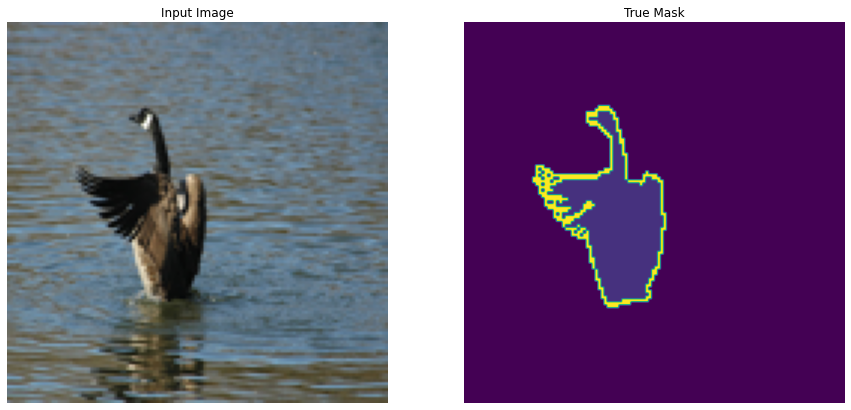

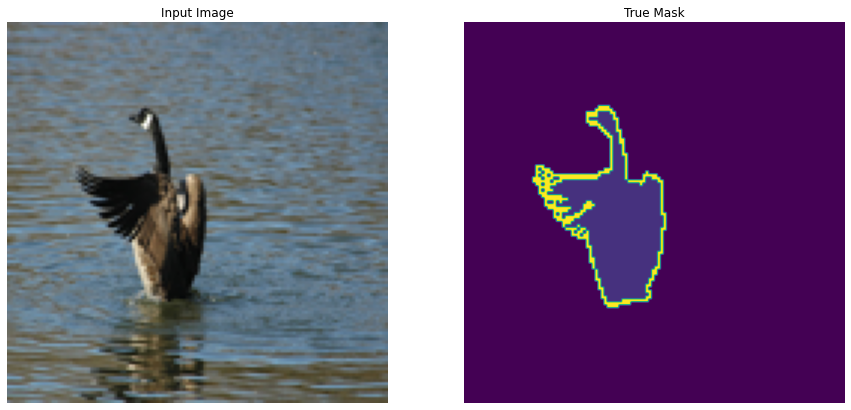

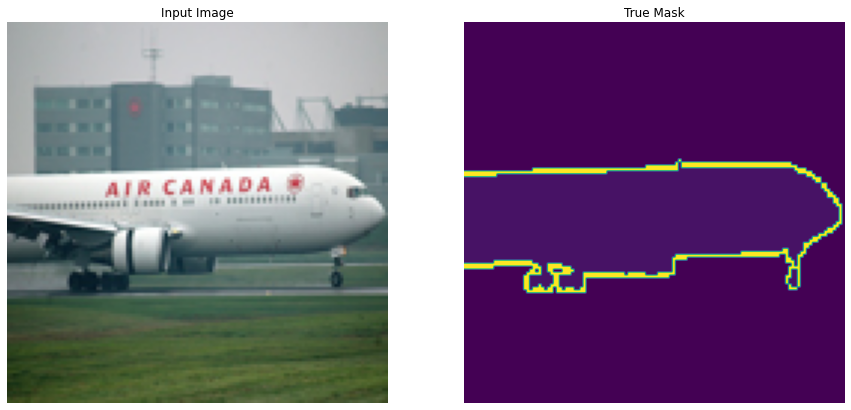

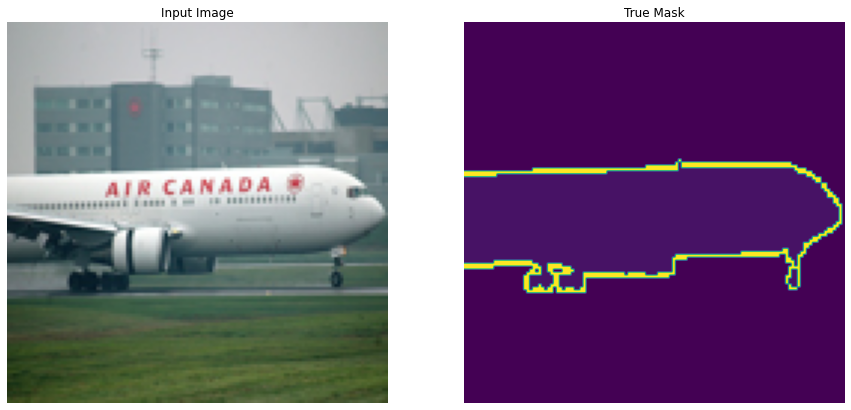

2021-10-04 22:20:05.660874: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [14]:
for images, masks in train_batches.take(2).cache():
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])
  aug = Augment()
  sample_image, sample_mask = aug.call(sample_image, sample_mask)
  display([sample_image, sample_mask])

In [15]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False)

# Use the activations of these layers
layer_names = [
    #'expanded_conv_project',   # 64x64
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [16]:
up_stack = [
    #pix2pix.upsample(1024, 3),
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [17]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=input_shape)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
OUTPUT_CLASSES = 22

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

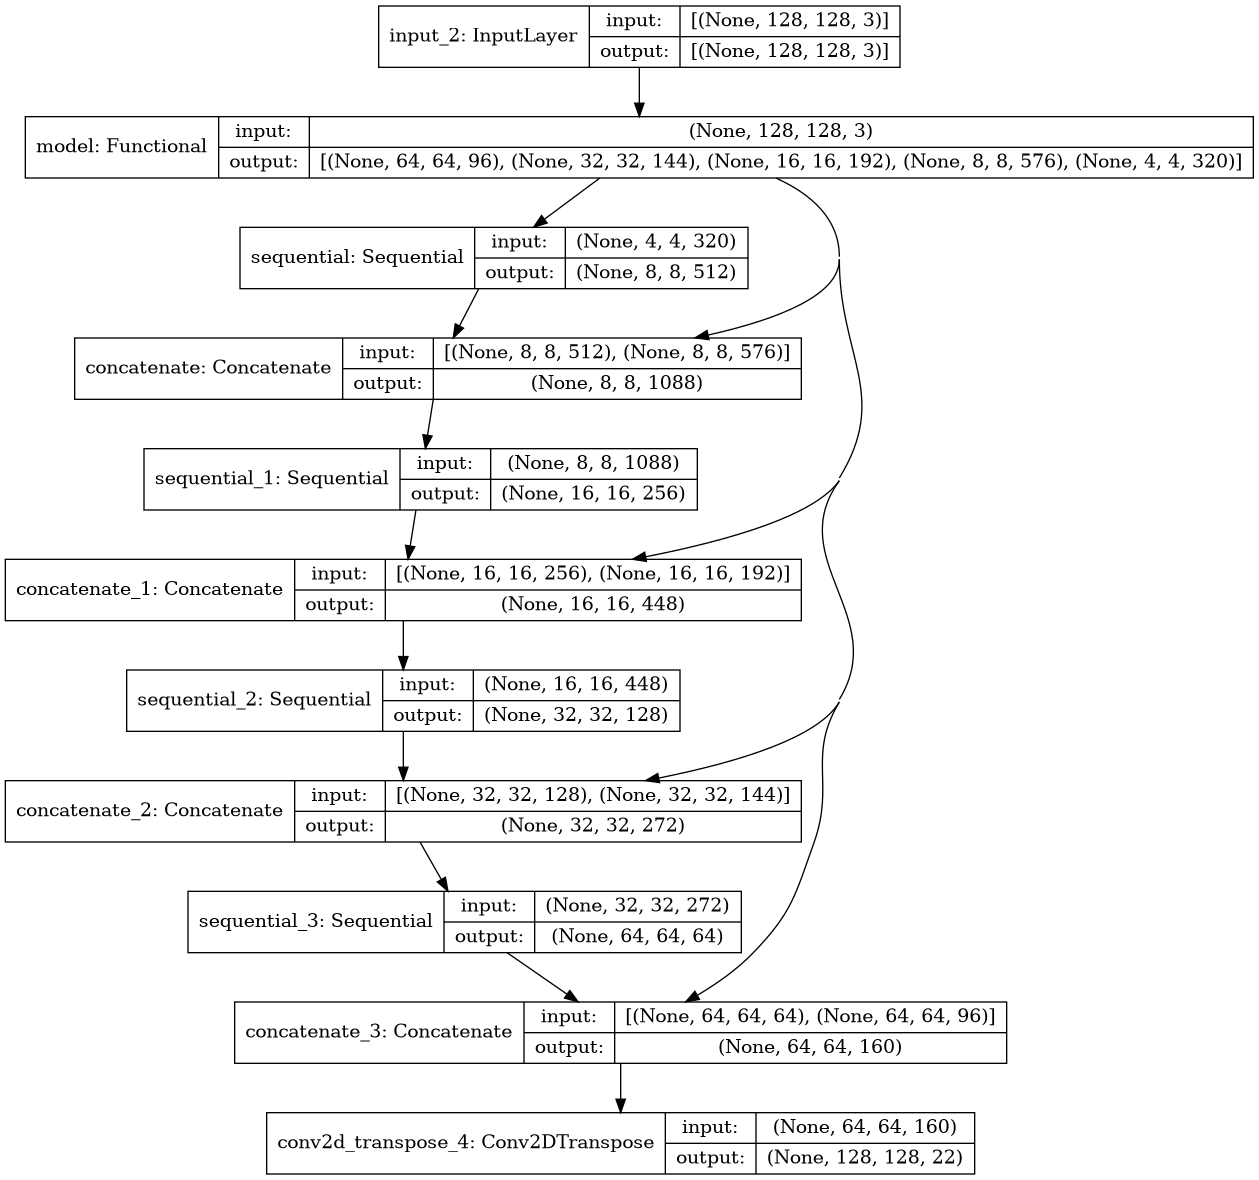

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [21]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

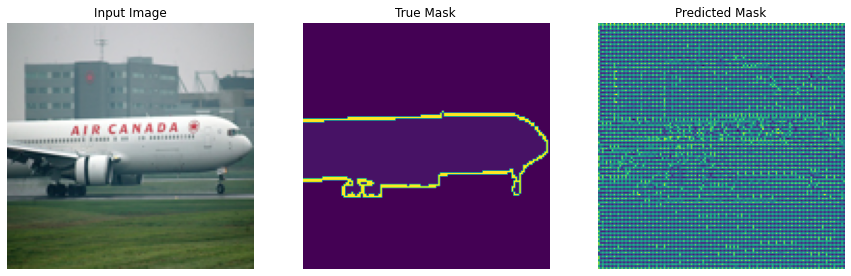

In [22]:
show_predictions()

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

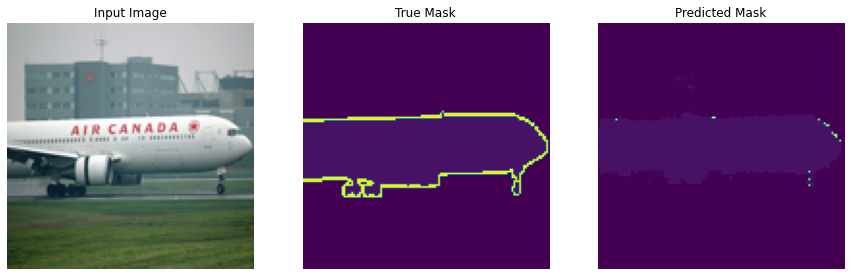


Sample Prediction after epoch 40



In [24]:
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 15
STEPS_PER_EPOCH = 100 #TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

In [25]:
model_history.history["val_accuracy"]

[0.6632012128829956,
 0.7230044007301331,
 0.721862256526947,
 0.7369153499603271,
 0.7512852549552917,
 0.7578954100608826,
 0.7686755061149597,
 0.7740224599838257,
 0.7735154032707214,
 0.7783980965614319,
 0.7769097089767456,
 0.7811638116836548,
 0.776606559753418,
 0.7792558073997498,
 0.778597354888916,
 0.7796106338500977,
 0.7704800963401794,
 0.7783525586128235,
 0.782936155796051,
 0.7801309823989868,
 0.7816219329833984,
 0.7880905866622925,
 0.7760010957717896,
 0.7818652391433716,
 0.7805015444755554,
 0.7860591411590576,
 0.7823439836502075,
 0.7663752436637878,
 0.7880791425704956,
 0.7854758501052856,
 0.7783538699150085,
 0.7750457525253296,
 0.7813368439674377,
 0.7821248769760132,
 0.7768279910087585,
 0.7793984413146973,
 0.7828930616378784,
 0.783612847328186,
 0.780279278755188,
 0.7829602360725403]

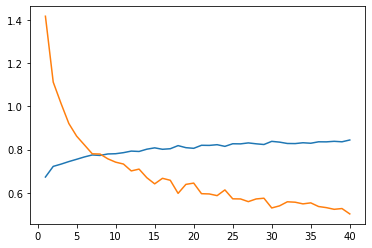

In [26]:
plt.plot(range(1, (EPOCHS+1)), model_history.history["accuracy"])
plt.plot(range(1, (EPOCHS+1)), model_history.history["loss"])
plt.show()



In [27]:
model.evaluate(test_batches)

16/16 [==============================] - 4s 255ms/step - loss: 0.6132 - accuracy: 0.8237


[0.6131998300552368, 0.8236650228500366]